In [2]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import recall_score, precision_score, f1_score 

In [3]:
datos_diabetes = pd.read_csv('/home/juan/machineLearning2025/datasets/diabetes_012_health_indicators_BRFSS2015.csv')
#Crear la columna diabetes_01 que unifique prediabetes con diabetes
datos_diabetes['diabetes_01'] = datos_diabetes['Diabetes_012']
datos_diabetes['diabetes_01'] = datos_diabetes['diabetes_01'].replace(2,1)

#Reparar nombres de columnas. Se usa el formato loweCamelCase para el nombre de las caracteristicas.

new_col_names = []

for name in datos_diabetes.columns:
    # Luego, pon todas las letras en minúsculas
    name_lowered_first_letter = name[0].lower() + name[1:]
    # Elimina los espacios al principio y al final
    name_stripped = name_lowered_first_letter.strip()
    # Por último, reemplaza los espacios entre palabras por guiones bajos
    name_no_spaces = name_stripped.replace(' ', '_')
    # Agrega el nuevo nombre a la lista de nuevos nombres de columna
    new_col_names.append(name_no_spaces)

datos_diabetes.columns = new_col_names

datos_diabetes = datos_diabetes.rename(columns={'bMI':'bmi'})

datos_diabetes.columns

datos_diabetes.drop(columns=['physHlth', 'mentHlth'], inplace=True)

In [4]:
#Funciones run_model() y evaluate_model()


def run_model(X_train, X_test, Y_train, Y_test):
    clf_base = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
    clf_base.fit(X_train, Y_train)
    return clf_base
def evaluate_model(model, train_features, train_target, test_features, test_target):
   
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')   
        
        eval_stats[type]['Exactitud'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return eval_stats['train']['F1'], eval_stats['test']['F1']

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from collections import Counter  
from imblearn.over_sampling import RandomOverSampler


X = datos_diabetes.drop(["diabetes_01", "diabetes_012"], axis=1)
y = datos_diabetes["diabetes_01"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

#Balanceamos con RandomOverSampler
os =  RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)
 
print ("before resampling {}".format(Counter(y_train)))
print ("after resampling {}".format(Counter(y_train_res)))


before resampling Counter({0.0: 160225, 1.0: 30035})
after resampling Counter({0.0: 160225, 1.0: 160225})


In [ ]:
##Utilizar un clasificador supervizado para asignar importancia a las caracteristicas.


from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split


# Entrenar el modelo ExtraTreesClassificator1
model_classificator = ExtraTreesClassifier(n_estimators=100, random_state=42) ##ensamble de 100 arboles
model_classificator.fit(X_train_res, y_train_res)

ExtraTreesClassifier(random_state=42)

                 Feature  Importance
3                    bmi    0.228211
16                   age    0.145901
18                income    0.101166
13               genHlth    0.097808
0                 highBP    0.084847
17             education    0.073989
1               highChol    0.044231
14              diffWalk    0.034815
8                 fruits    0.027791
4                 smoker    0.027555
15                   sex    0.021979
9                veggies    0.021182
7           physActivity    0.019968
6   heartDiseaseorAttack    0.019147
12           noDocbcCost    0.014774
5                 stroke    0.010656
11         anyHealthcare    0.009429
10     hvyAlcoholConsump    0.009310
2              cholCheck    0.007240
Número óptimo de características: 4


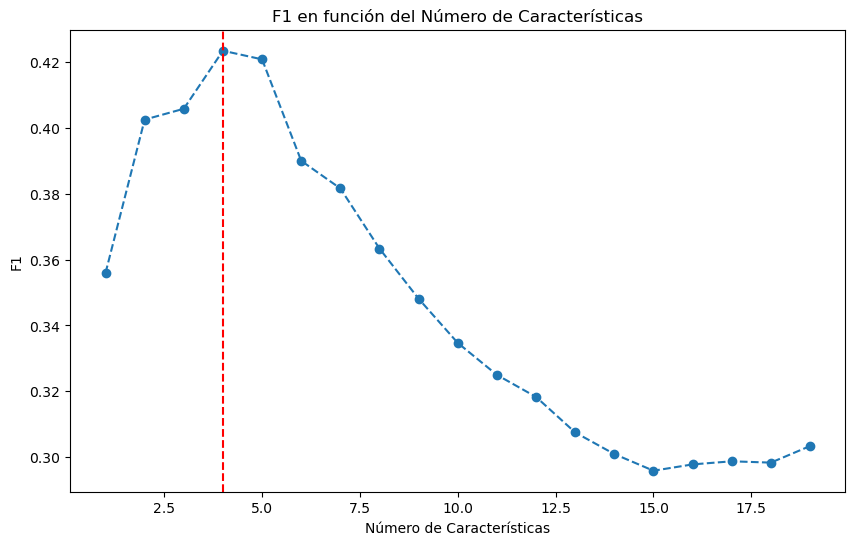

In [ ]:
# Obtener las importancias de las características SEGUN LA METRICA DE F1

##Significado de importacia: reduccion de indice gini de cada caracteristica.
importances = model_classificator.feature_importances_

# Crear un DataFrame con las características y sus importancias
feature_importances = pd.DataFrame({"Feature": X.columns, "Importance": importances})

# Ordenar las características por importancia
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

print(feature_importances)



# Ahora evaluaremos le modelo de ensamble variando el numero de caracteristicas para evaluar su rendimiento.
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
results = []
for i in range(1, len(feature_importances) + 1):
    selected_features = feature_importances["Feature"][:i]
    X_train_selected = X_train_res[selected_features]
    X_test_selected = X_test[selected_features]

    model_classificator.fit(X_train_selected, y_train_res)
    y_pred = model_classificator.predict(X_test_selected)
    f1 = f1_score(y_test, y_pred)
    acc= accuracy_score(y_test, y_pred)
    results.append((i, f1, acc))

# Convertir los resultados a un DataFrame
results_df = pd.DataFrame(results, columns=["Number of Features", "F1", "Accuracy"])

# Encontrar el número óptimo de características
optimal_features = results_df.loc[results_df["F1"].idxmax(), "Number of Features"]
print(f"Número óptimo de características: {optimal_features}")

# Graficar el ECM en función del número de características
plt.figure(figsize=(10, 6))
plt.plot(
    results_df["Number of Features"], results_df["F1"], marker="o", linestyle="--"
)
plt.xlabel("Número de Características")
plt.ylabel("F1")
plt.title("F1 en función del Número de Características")
plt.axvline(optimal_features, color="r", linestyle="--")
plt.show()

# Guarda el df con la importancia 
feature_importances.to_csv('feature_importances_extratreeclassificator_RandOverSampler.csv', index=False)

# Guarda el df con los resultados de MSE
results_df.to_csv('results_extratreeclassificator_RandOverSampler.csv', index=False)



In [7]:
#Veremos ahora las caracteristicas mas importantes de este dataset balanceado *****ExtraTreeRegressor:

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error

# Entrenar el modelo ExtraTreesRegressor
model_regressor = ExtraTreesRegressor(n_estimators=100, random_state=42) ##ensamble de 100 arboles
model_regressor.fit(X_train_res, y_train_res)

ExtraTreesRegressor(random_state=42)

In [8]:
# Obtener las importancias de las características

##Significado de importacia: reduccion de indice gini de cada caracteristica.
importances = model_regressor.feature_importances_

# Crear un DataFrame con las características y sus importancias
feature_importances = pd.DataFrame({"Feature": X.columns, "Importance": importances})

# Ordenar las características por importancia
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

# Mostrar las características más importantes
print(feature_importances)



                 Feature  Importance
3                    bmi    0.166879
0                 highBP    0.139885
16                   age    0.118124
18                income    0.106583
13               genHlth    0.090018
17             education    0.083171
4                 smoker    0.039861
8                 fruits    0.038980
7           physActivity    0.032792
9                veggies    0.031502
14              diffWalk    0.026943
15                   sex    0.026432
1               highChol    0.020780
12           noDocbcCost    0.019376
6   heartDiseaseorAttack    0.016190
5                 stroke    0.014957
11         anyHealthcare    0.011658
10     hvyAlcoholConsump    0.009694
2              cholCheck    0.006177


Número óptimo de características: 19


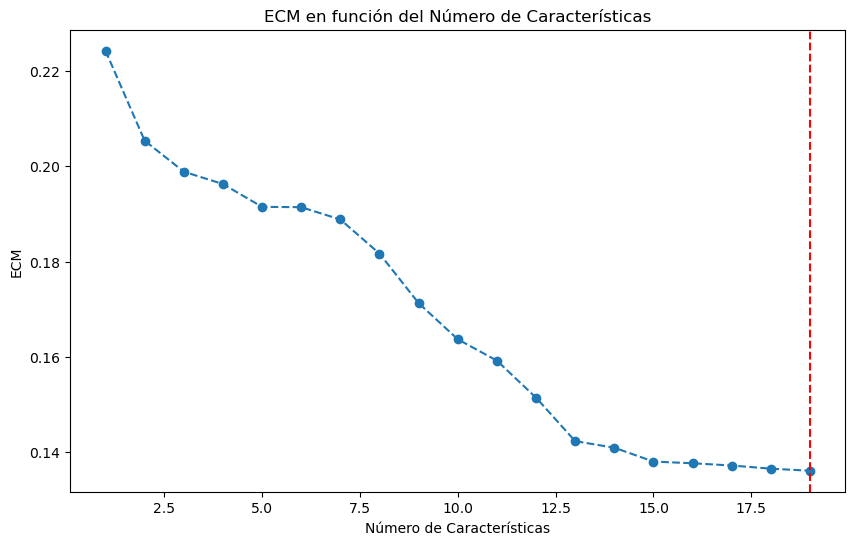

In [9]:
# Ahora evaluaremos le modelo de ensamble variando el numero de caracteristicas para evaluar su rendimiento.

results = []
for i in range(1, len(feature_importances) + 1):
    selected_features = feature_importances["Feature"][:i]
    X_train_selected = X_train_res[selected_features]
    X_test_selected = X_test[selected_features]

    model_regressor.fit(X_train_selected, y_train_res)
    y_pred = model_regressor.predict(X_test_selected)
    mse = mean_squared_error(y_test, y_pred)
    results.append((i, mse))

# Convertir los resultados a un DataFrame
results_df = pd.DataFrame(results, columns=["Number of Features", "MSE"])

# Encontrar el número óptimo de características
optimal_features = results_df.loc[results_df["MSE"].idxmin(), "Number of Features"]
print(f"Número óptimo de características: {optimal_features}")

# Graficar el ECM en función del número de características
plt.figure(figsize=(10, 6))
plt.plot(
    results_df["Number of Features"], results_df["MSE"], marker="o", linestyle="--"
)
plt.xlabel("Número de Características")
plt.ylabel("ECM")
plt.title("ECM en función del Número de Características")
plt.axvline(optimal_features, color="r", linestyle="--")
plt.show()

# Guarda el df con la importancia 
feature_importances.to_csv('feature_importances_extratreeregressor_RandOverSampler.csv', index=False)

# Guarda el df con los resultados de MSE
results_df.to_csv('results_extratreeregressor_RandOverSampler.csv', index=False)


PROBAR REGRESION LOGISTICA Y ARBOL DE DESICION PARA LAS 4 MEJORES CARACTERISTICAS QUE SE EXTRAJERON DESPUES DE BALANCEAR CON RandomOversample.

In [1]:
X_train_selected = X_train_res[['bmi', 'highBP', 'age', 'genHlth']]
X_test_selected = X_test[['bmi', 'highBP', 'age', 'genHlth']]

#model_feature_selection = ExtraTreesRegressor(n_estimators=100, random_state=42) ##ensamble de 100 arboles
#model_feature_selection.fit(X_train_selected, y_train_res)
#train_f1, test_f1 = evaluate_model(model, X_train_selected, y_train_res, X_test_selected, y_test)

X_test_selected


NameError: name 'X_train_res' is not defined